# Modeling

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
import pandas as pd
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, HistGradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, PrecisionRecallDisplay, precision_recall_curve
import seaborn as sns
import matplotlib.pyplot as plt
sys.path.append("../src")
import utils

# rng = np.random.default_rng(10)

## Outline

1. Models and hyperparameters
    1. Naive model
        - Assign a random probability to each case
    1. SVM using `decision_function` for threshold estimates?
    1. Logistic regression
        - Regularization measures (L1, L2)
        - Regularization parameter
        - If using SGD: learning rate
    1. Kernel SGD logistic model
        - Polynomial of various degress
        - Radial basis
        - Number of components to approximate (100, 500, 1000)
    1. Random forest
        - Tree depth
        - Forest size
    1. Ada boost
        - Learning rate
        - Tree parameters
    1. Gradient boost
        - Learning rate
        - Tree parameters
    1. Baby recurrent neural network
        - 1 layer of <100 nodes
        - Gate parameters?
1. Metrics for model tuning by cross-validation
    1. F1 score (to balance precision and recall)? `f1`
    1. Negative log loss (to capture probabilistic closeness)? `neg_log_loss`
    1. Minimum false positive rate with recall of at least 75%. This can be defined as a custom scoring function with `sklearn.metrics.make_scorer(score_func, needs_threshold=True)`
1. Comparing models
    - Minimum false positive rate with recall of at least 75%
    - Are there more false positives based on different features?

## 0. Preface

As an introduction to the scope of the problem, let's begin by fitting a logistic regression with default parameters on the (smaller) balanced data. This is done in the next two code cells. The third code presents metrics for the model: classification reports for both training and test data, and a detail of the precision-recall curve for the testing data. These show a model that is able to catch fraud cases in the test data only at the expense of a large number of false positives: catching three quarters of fraud cases requires almost 50 false positives for every accurate fraud label.

The question, then, is how much lower can we get this false positive rate while still flagging a large share of fraudulent transactions for further investigation? This last point is important: a "false positive" can mean, in practice, declining a transaction until it is confirmed by the user, for example by responding to a text message. This is certainly a nuisance for customers, but it can be weighed against the benefit of preemptively catching a larger share of fraudulent activity.

In [4]:
# load balanced training data and test data
X_train = pd.read_csv(utils.prepend_dir('tx_train_balanced.csv'))
X_test = pd.read_csv(utils.prepend_dir('tx_test.csv'))

y_train = X_train.is_fraud
X_train.drop(columns='is_fraud', inplace=True)

y_test = X_test.is_fraud
X_test.drop(columns='is_fraud', inplace=True)
X_train.shape, X_test.shape, y_train.shape, y_test.shape


((27599, 28), (1176707, 28), (27599,), (1176707,))

In [5]:
# define and fit model
default_logit_pipe = make_pipeline(
    utils.MCCRates(),
    utils.MakeDummies('errors'),
    StandardScaler(),
    LogisticRegression()
    # SGDClassifier('log_loss')
)

default_logit_pipe.fit(X_train, y_train)
y_pred_train = default_logit_pipe.predict(X_train)
y_pred_test = default_logit_pipe.predict(X_test)

Training:
              precision    recall  f1-score   support

       False       0.89      0.87      0.88     13749
        True       0.87      0.89      0.88     13850

    accuracy                           0.88     27599
   macro avg       0.88      0.88      0.88     27599
weighted avg       0.88      0.88      0.88     27599

Validation:
              precision    recall  f1-score   support

       False       1.00      0.87      0.93   1175292
        True       0.01      0.91      0.02      1415

    accuracy                           0.87   1176707
   macro avg       0.50      0.89      0.47   1176707
weighted avg       1.00      0.87      0.93   1176707



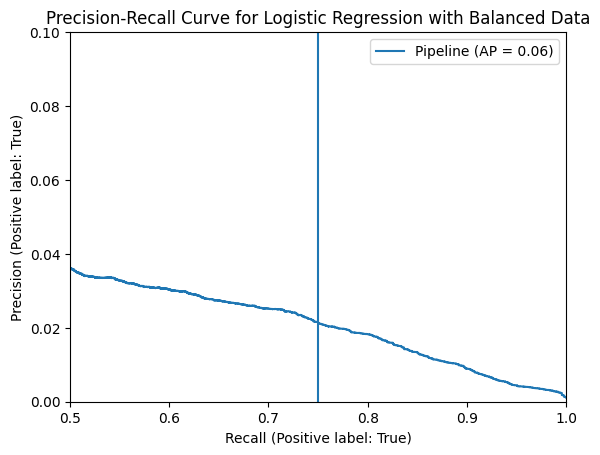

In [6]:
# show metrics
print('Training:')
print(classification_report(y_train, y_pred_train))
print('Validation:')
print(classification_report(y_test, y_pred_test))
prc_display = PrecisionRecallDisplay.from_estimator(default_logit_pipe, X_test, y_test)
plt.axvline(0.75);
plt.axis([0.5, 1., 0., 0.1]);
plt.legend(loc='upper right');
plt.title("Precision-Recall Curve for Logistic Regression with Balanced Data");

In [11]:
# memory is a constraint on my personal computer, so deleting everything from this preliminary analysis
del X_train, y_train, X_test, y_test, default_logit_pipe

## 1. Framework

This section sets up the models and parameter grids that will be assessed below. All information on models will be combined into list of dictionaries, each with the following elements:
1. `name`: A descriptive name
1. `estimator`: The full model pipeline, including needed transformations. Each pipeline consists of the replacement of `MCC` codes, the conversion of categorical variables (with or without drop-first dummy encoding), and standardization if necessary.
1. `paramaters`: A dictionary to be passed to `RandomSearchCV` for hyperparameter tuning.
1. `gridsize`: An integer indicating how many unique combinations of parameters there are. This will be used to determine the kind of search to perform.

In [12]:
# Shared transformers
mcc_convert = utils.MCCRates()
cat_convert_dummies = utils.MakeDummies('errors')
cat_convert_onehot = utils.MakeDummies('errors', drop_first=False)
standardize = StandardScaler()
# List containing the model information dictionaries
models = {}

def make_pipe_params(name, params):
    '''Appends the model name for setting parameters in a pipeline'''
    return {f'{name}__{key}':value for key, value in params.items()}

def gridsize(params):
    '''Counts the number of hyperparameters. Return a tuple of (number unique combinations, number of distinct values)'''
    total_prod = 1
    total_sum = 0
    for _, vals in params.items():
        total_prod *= len(vals)
        total_sum += len(vals)
    return total_prod, total_sum

def model_dict(name, components, params):
    return {
        'pipeline': make_pipeline(*components),
        'parameters': make_pipe_params(name, params),
        'gridsize': gridsize(params)
    }

Naive baseline "model": assigning a random probability to each case. No transformations are used here because they are irrelevant to the prediction.

In [13]:
models['naive'] = {
    'pipeline': utils.NaiveClassifier(),
    'parameters': {},
    'gridsize': (1, 1)
}

### Logistic regression

Requires drop-one encoding and standardization. Hyperparameters:
- C (regularization parameter): `1e-3...1e2`

In [14]:
name = 'logisticregression'
components = [
    mcc_convert,
    cat_convert_dummies,
    standardize,
    LogisticRegression(class_weight='balanced', max_iter=1000)
]

parameters = {
    # 'penalty': ['l1', 'l2'],
    'C': [10.**x for x in range(-3, 3)]
}

models[name] = model_dict(name, components, parameters)

### SGD with alternative loss functions and regularization

The solvers for scikit-learn's `LogisticRegression` model that are compatible with penalties other than `L2` fail to converge in a reasonable time frame. `SGDClassifier` is compatible with `elasticnet` penalty, which combines L1 and L2 (and can be equivalent to them with the appropriate parameter).

Hyperparameters:
- Loss function: log (like logistic regression), modified Huber
- Regularization parameter (alpha, higher is stronger): 1e-6 ... 1e2
- L1 ratio: 0 (=L2 penalty), 0.1, 0.2 ... 1 (=L1 penalty)

In [15]:
name = 'sgdclassifier'

components = [
    mcc_convert,
    cat_convert_dummies,
    standardize,
    SGDClassifier(class_weight='balanced', penalty='elasticnet')
]

parameters = {
    'loss': ['log_loss', 'modified_huber'],
    'alpha': [10**x for x in range(-6, 3)],
    'l1_ratio': [x/10. for x in range(11)]
}

models[name] = model_dict(name, components, parameters)

### Kernel SVM

Requires drop-one encoding and standardization. Note that the precision-recall curve will be calculated using `.decision_function()`, which is based on distance from the separating hyperplane. Hyperparameters:
- C (regularization parameter): `1e-3...1e1`
- Kernel: `poly`, `rbf`
- Degree (for polynomial): `2...4`
- Gamma (kernel weight parameter): `scale`, `auto`, `1e-3...1e0`

In [16]:
# components = [
#     mcc_convert,
#     cat_convert_dummies,
#     standardize,
#     SVC(class_weight='balanced', max_iter=1000)
# ]

# parameters = {
#     'C': [10.**x for x in range(-3, 2)],
#     'kernel': ['poly', 'rbf'],
#     'degree': list(range(2, 5)),
#     'gamma': ['scale', 'auto'] + [10.**x for x in range(-3, 1)]
# }

# models.append(model_dict('svc', components, parameters))

### Random Forest

Does not require drop-first encoding or standardization. Hyperparameters:
- Number of estimators: 50, 100, 200, 400, 800
- Maximum depth of trees: None, 10, 20, 40
- Minimum samples per leaf: 1, 10, 50
- Complexity parameter for minimal cost-complexity pruning: `1e-3 ... 1e-1`
- Class weight: 'balanced', 'balanced_subsample'

Note that although random forests can be fit in parallel, the parameter search functions will be set for parallelize instead.

In [17]:
name = 'randomforestclassifier'

components = [
    mcc_convert,
    cat_convert_onehot,
    RandomForestClassifier()
]

parameters = {
    'n_estimators': [50*2**x for x in range(5)],
    'max_depth': [None, 10, 20, 40, 80],
    'min_samples_leaf': [1, 10, 50, 100],
    'ccp_alpha': [0.0] + [10**x for x in range(-3, 0)],
    'class_weight': ['balanced', 'balanced_subsample']
}

models[name] = model_dict(name, components, parameters)

### AdaBoost

Does not require drop-first encoding or standardization. Hyperparameters:
- Number of estimators: 50, 100, 200, 400, 800
- Learning rate: `1e-4...1`

In [18]:
name = 'adaboostclassifier'

components = [
    mcc_convert,
    cat_convert_onehot,
    AdaBoostClassifier()
]

parameters = {
    'n_estimators': [50*2**x for x in range(5)],
    'learning_rate': [10.**x for x in range(-4, 1)]
}

models[name] = model_dict(name, components, parameters)

### XGBoost

Does not require drop-first encoding or standardization. Hyperparameters:
- Learning rate: `1e-2...1e1`
- Max depth of trees: 2, 4, 8, 16
- Minimum child weight: 1, 10

In [19]:
name = 'xgbclassifier'

components = [
    mcc_convert,
    cat_convert_onehot,
    XGBClassifier(objective='binary:logistic')
]

parameters = {
    'learning_rate': [10.**x for x in range(-4, 4)],
    'max_depth': [2*2**x for x in range(5)],
    'min_child_weight': [1, 10, 20, 30]
}

models[name] = model_dict(name, components, parameters)

## 2. Tuning

This section measured the performance of the various model and hyperparamter combinations with 5-fold cross-validation. It uses both the balanced and unbalanced training data sets. Model performance is measured with F1 scores, because not every model can output probabilities. For the best-performing estimator is then saved for evaluation later.

Note: the hyperparameter search is performed differently based on the size of the grid:
- For up to 50 parameter combinations: exhaustive grid search.
- For more than 50 combinations: random search with $3n$ samples, where $n$ is the sum of distinct hyperparameter values.

### 2.1 Balanced data

In [20]:
# Loading data

X_train = pd.read_csv(utils.prepend_dir('tx_train_balanced.csv'))
y_train = X_train.is_fraud
X_train.drop(columns='is_fraud', inplace=True)

# Iterating through models
for name, model in models.items():
    combinations, count = model['gridsize']
    print(f'{name}: {combinations = } vs. iterations = {count*3}')
    
    # Determine search method: grid or randomized
    if combinations <= 50 or combinations <= count*3:
        searcher = GridSearchCV(
            model['pipeline'], 
            param_grid=model['parameters'], 
            n_jobs=-1, 
            scoring='f1',
            verbose=1)
    else: 
        searcher = RandomizedSearchCV(
            model['pipeline'], 
            param_distributions=model['parameters'], 
            n_iter=count*3, 
            n_jobs=-1, 
            scoring='f1',
            verbose=1)
    
    searcher.fit(X_train, y_train)
    
    # print and save results
    print(searcher.best_score_, searcher.best_params_)
    results = {
        'best_estimator': searcher.best_estimator_,
        'best_params': searcher.best_params_,
        'best_score': searcher.best_score_,
        'results_table': pd.DataFrame(searcher.cv_results_)
    }
    model.update(results)

naive: combinations = 1 vs. iterations = 3
Fitting 5 folds for each of 1 candidates, totalling 5 fits
0.5015150777505518 {}
logisticregression: combinations = 6 vs. iterations = 18
Fitting 5 folds for each of 6 candidates, totalling 30 fits
0.880209063282335 {'logisticregression__C': 10.0}
sgdclassifier: combinations = 176 vs. iterations = 63
Fitting 5 folds for each of 63 candidates, totalling 315 fits
0.8790897171070554 {'sgdclassifier__loss': 'log_loss', 'sgdclassifier__l1_ratio': 1.0, 'sgdclassifier__alpha': 0.0001}
randomforestclassifier: combinations = 800 vs. iterations = 60
Fitting 5 folds for each of 60 candidates, totalling 300 fits
0.9074326608898101 {'randomforestclassifier__n_estimators': 400, 'randomforestclassifier__min_samples_leaf': 10, 'randomforestclassifier__max_depth': None, 'randomforestclassifier__class_weight': 'balanced_subsample', 'randomforestclassifier__ccp_alpha': 0.0}
adaboostclassifier: combinations = 25 vs. iterations = 30
Fitting 5 folds for each of 25 

### 2.2 Unbalanced data

## 3. Evaluation

In [21]:
def assess_model(model, name, X_test, y_test):
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))
    test_fraud_prob = model.predict_proba(X_test)[:,1]

    # precision-recall plot
    # _ = PrecisionRecallDisplay.from_estimator(model, X_test, y_test)
    _ = PrecisionRecallDisplay.from_predictions(y_test, test_fraud_prob)
    plt.axvline(0.75, color='red');
    plt.axis([0.5, 1., 0., 0.25]);
    plt.legend(loc='upper right');
    plt.title(f"Precision-Recall Curve for {name}");
    
    # save precision-recall table
    precision, recall, thresholds = precision_recall_curve(y_test, test_fraud_prob)
    prc = pd.DataFrame({
        'precision':precision[:-1],
        'recall': recall[:-1]},
        index=thresholds
    )
    return prc[prc.recall>=0.75].precision.max()

********naive********
********logisticregression********
logisticregression__C    10.0
dtype: float64
              precision    recall  f1-score   support

       False       1.00      0.87      0.93   1175292
        True       0.01      0.91      0.02      1415

    accuracy                           0.87   1176707
   macro avg       0.50      0.89      0.47   1176707
weighted avg       1.00      0.87      0.93   1176707


********sgdclassifier********
sgdclassifier__loss        log_loss
sgdclassifier__l1_ratio         1.0
sgdclassifier__alpha         0.0001
dtype: object
              precision    recall  f1-score   support

       False       1.00      0.86      0.93   1175292
        True       0.01      0.91      0.02      1415

    accuracy                           0.86   1176707
   macro avg       0.50      0.89      0.47   1176707
weighted avg       1.00      0.86      0.93   1176707


********randomforestclassifier********
randomforestclassifier__n_estimators               

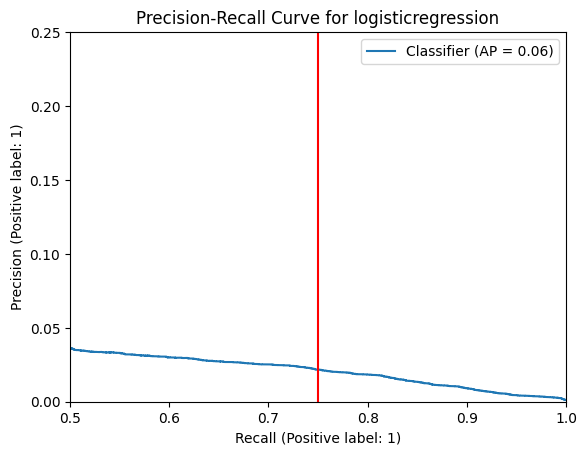

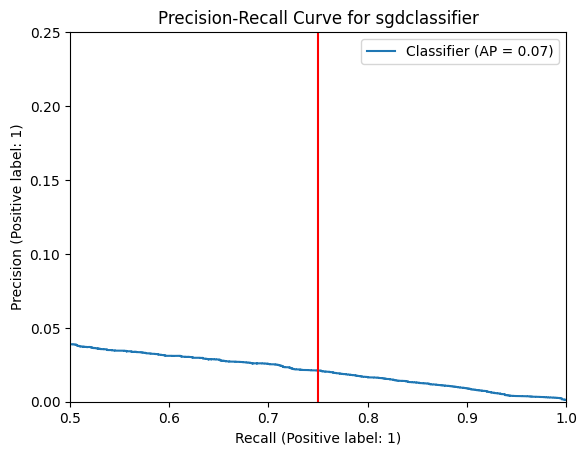

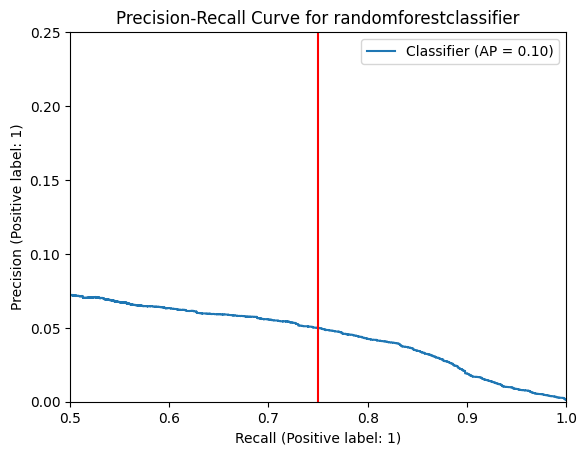

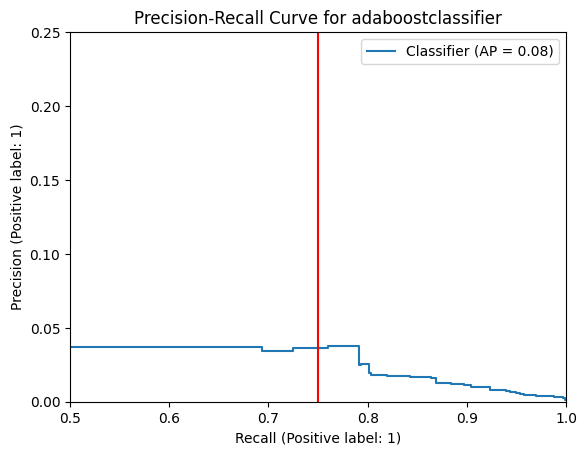

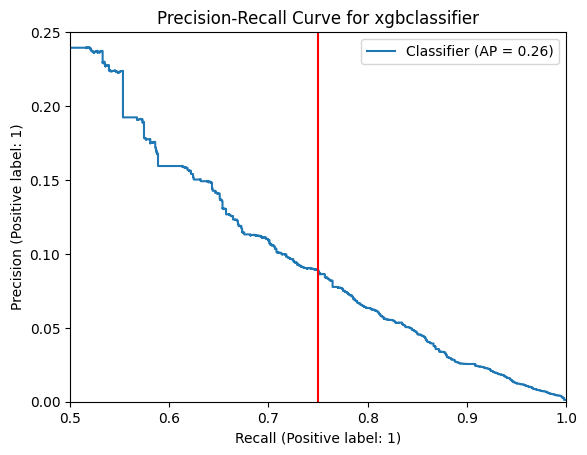

In [24]:
X_test = pd.read_csv(utils.prepend_dir('tx_test.csv'))
y_test = X_test.is_fraud
X_test.drop(columns='is_fraud', inplace=True)
names = []
prec75 = []

for name, model in models.items():
    print(f'********{name}********')
    # if name=='naive': continue
    print(pd.Series(model['best_params']))
    model['prec75'] = assess_model(model['best_estimator'], name, X_test, y_test)
    names.append(name)
    prec75.append(model['prec75'])
    print()

In [23]:
recall_data = pd.DataFrame({'names': names, 'prec75':prec75})
recall_data['false_positives_per_true'] = 1/ recall_data.prec75 - 1
recall_data.sort_values('recall75', ascending=False)

,names,recall75,false_positives_per_true
4,xgbclassifier,0.088930,10.244821
2,randomforestclassifier,0.049937,19.025400
3,adaboostclassifier,0.037421,25.722967
0,logisticregression,0.021665,45.158192
1,sgdclassifier,0.021141,46.300377
